# 1) Cargamos la data y armamos la mesa de trabajo

* Dataset a usar: E-Commerce Sales Dataset de Kaggle.
* Fuente: https://www.kaggle.com/datasets/thedevastator/unlock-profits-with-e-commerce-sales-data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('Configuración completa')

Configuración completa


In [2]:
# Cargammos el dataset

ruta = '/workspaces/The-Stock-Stack/datasets/amazon_sale_report.csv'
df = pd.read_csv(ruta)

print('Dataset cargado')

Dataset cargado


/tmp/ipykernel_43155/1385647125.py:4: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta)


In [3]:
# Revisamos la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [4]:
# Delimitamos la cantidad de datos que poseemos
print(f'Cantidad de filas : {df.shape[0]}')
print(f'Cantidad de columnas : {df.shape[1]}')
print(f'Tenemos {df.shape[0]*df.shape[1]} datos en el dataset')

Cantidad de filas : 128975
Cantidad de columnas : 24
Tenemos 3095400 datos en el dataset


# 2) Hacemos el análisis de nulos y duplicados

In [5]:
# Revisamos si no hay entradas duplicadas
print(f'Cantidad de filas duplicadas : {df.duplicated().sum()}')

Cantidad de filas duplicadas : 0


In [6]:
# Hacemos un conteo de nulos por columna
df.isnull().sum()

index                     0
Order ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales Channel             0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
currency               7795
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
ship-country             33
promotion-ids         49153
B2B                       0
fulfilled-by          89698
Unnamed: 22           49050
dtype: int64

<Axes: >

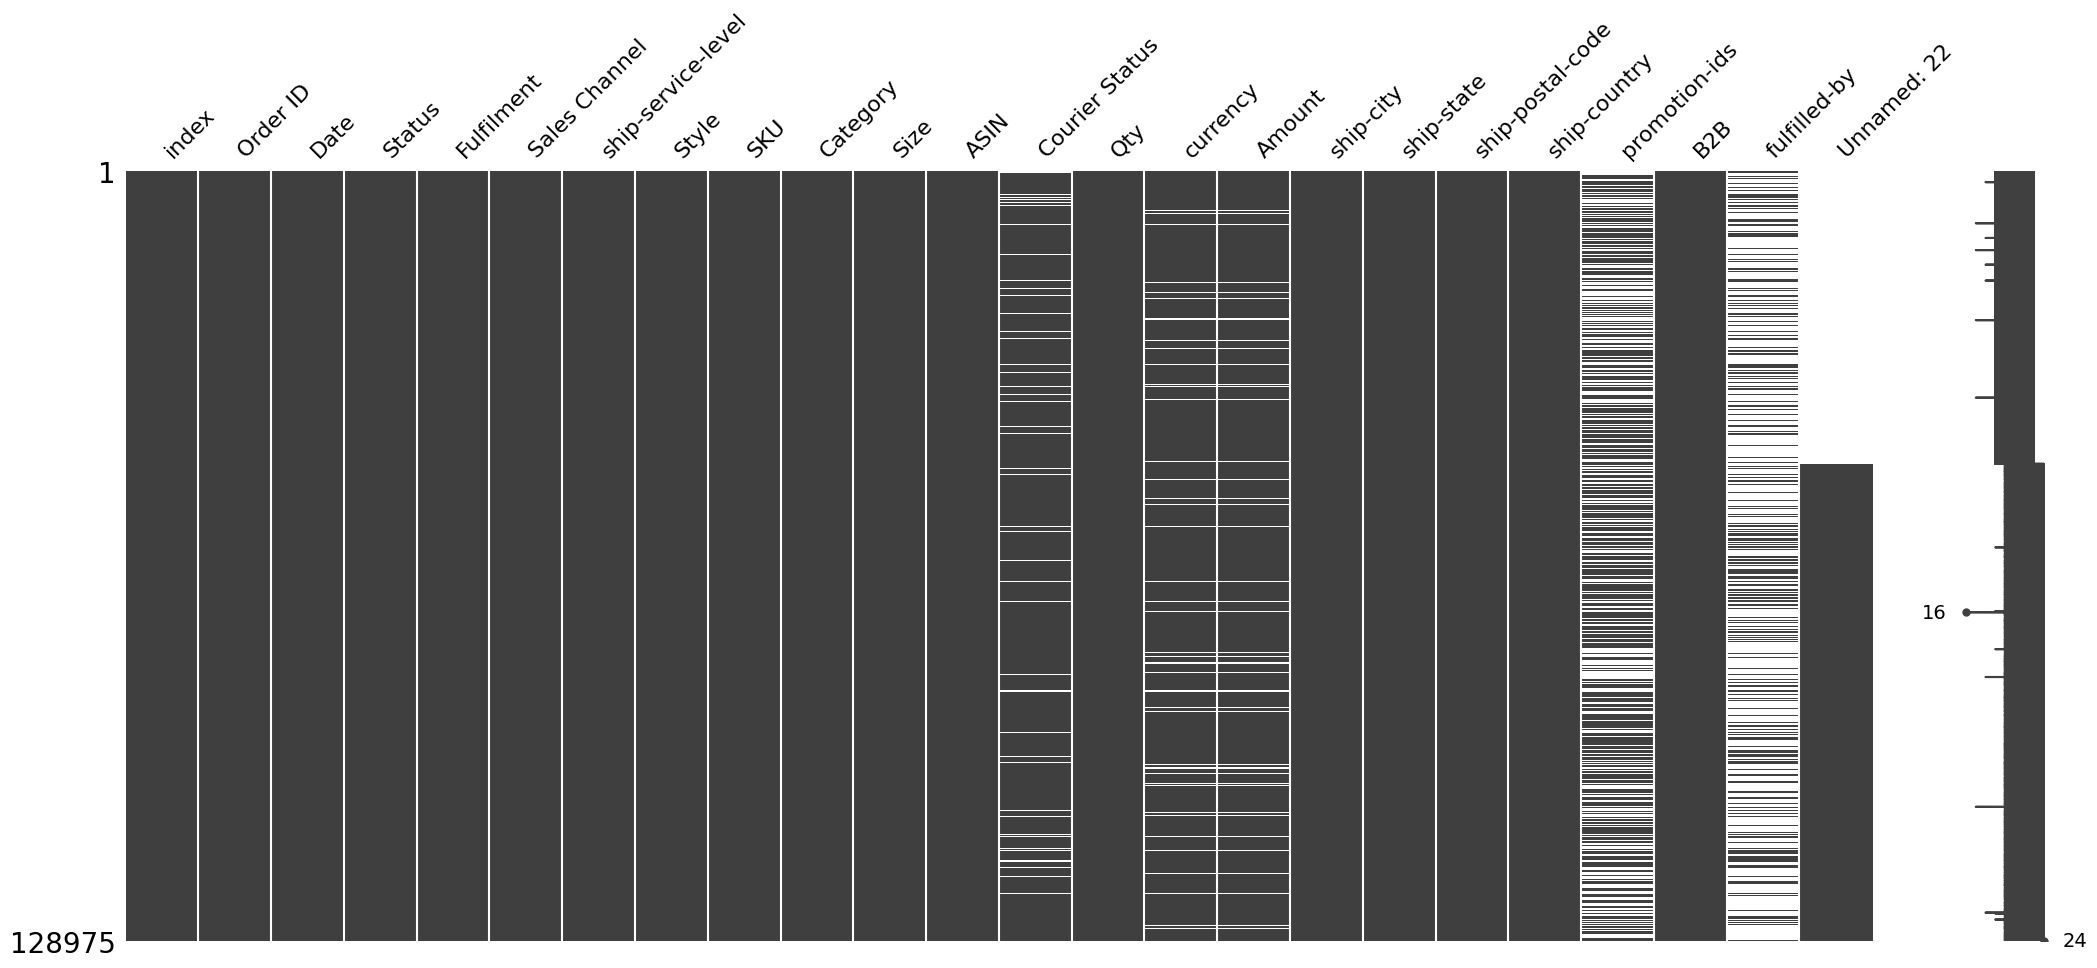

In [7]:
# usamos missingno para visualizar los nulos
import missingno as msno
msno.matrix(df)

Contexto de la gráfica: muestra cada columna como un bloque vertical. Cada espacio en blanco es una discontinuidad. Cada discontinuidad es un nulo.

Insight: La currency en este caso es INR, y el amount es la cantidad de currency desembolsada por el cliente en la compra. Naturalmente, si no tenemos la currency, menos tendremos el amount. Para el análisis de la demanda podemos omitirlos, pero nos puede servir tenerlos a la mano para hacer un estimado de ganancias por ventas. Recomiendo inputarlos. 

Insight: Según https://www.exchange-rates.org/es/historial/inr-usd-2022, en el año de 2022, en promedio cada rupia equivalía a 0,01274 USD durante este período. Podemos usar esto como factor de cambio para el cálculo de ganancias en USD.

In [8]:
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

# Creamos un DataFrame para mostrar los resultados
tabla_nulos = pd.DataFrame({
    'Columna': porcentaje_nulos.index,
    'Porcentaje de Nulos': porcentaje_nulos.values
})

# Filtramos solo las columnas con nulos
tabla_nulos = tabla_nulos[tabla_nulos['Porcentaje de Nulos'] > 0].sort_values(by='Porcentaje de Nulos', ascending=False)

tabla_nulos

,Columna,Porcentaje de Nulos
22,fulfilled-by,69.546811
20,promotion-ids,38.110487
23,Unnamed: 22,38.030626
14,currency,6.043807
15,Amount,6.043807
12,Courier Status,5.328164
18,ship-postal-code,0.025586
17,ship-state,0.025586
16,ship-city,0.025586
19,ship-country,0.025586


Columnas que se deciden eliminar por juicio propio:
* "Fulfilled-by": exceso de nulos y no tiene que ver con el proceso compra-venta (solo da visibilidad del proceso administrativo de quién llenó la fila).
* "Unnamed: 22": ni idea de por qué está allí. Si no es nulo es false, y no indica nada.

In [9]:
# Eliminamos fulfilled-by y Unnamed: 22
df = df.drop(['fulfilled-by', 'Unnamed: 22'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [10]:
# Recalculamos las dimensiones del dataset
print(f'Cantidad de filas : {df.shape[0]}')
print(f'Cantidad de columnas : {df.shape[1]}')
print(f'Tenemos {df.shape[0]*df.shape[1]} datos en el dataset')

Cantidad de filas : 128975
Cantidad de columnas : 22
Tenemos 2837450 datos en el dataset


<Axes: >

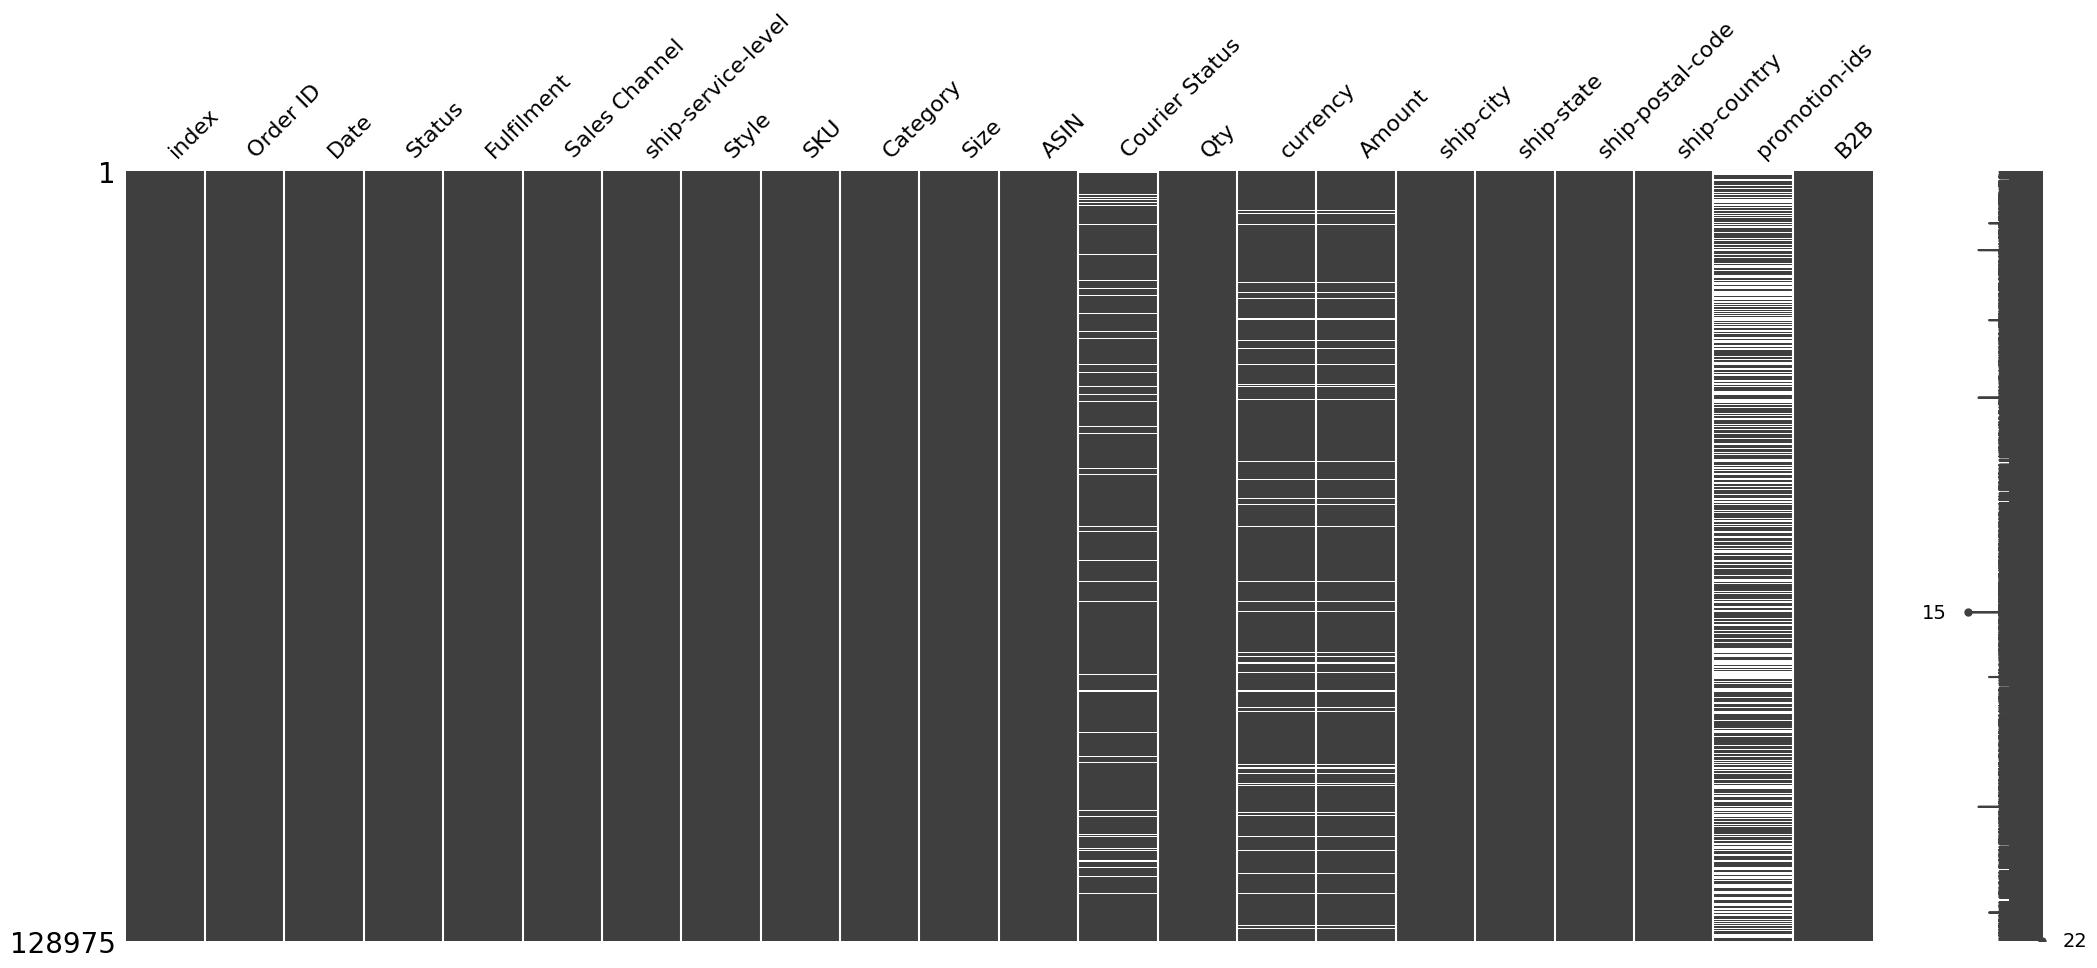

In [11]:
# Volvemos a usar missingno para visualizar los nulos
import missingno as msno
msno.matrix(df)

In [12]:
# Hacemos que la columna "index" sea el índice del dataframe
df = df.set_index('index')

In [13]:
df

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,...,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B
index,,,,,,,,,,,,,,,,,,,,,
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True
3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,...,NaN,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,406-6001380-7673107,05-31-22,Shipped,Amazon,Amazon.in,Expedited,JNE3697,JNE3697-KR-XL,kurta,XL,...,Shipped,1,INR,517.00,HYDERABAD,TELANGANA,500013.0,IN,NaN,False
128971,402-9551604-7544318,05-31-22,Shipped,Amazon,Amazon.in,Expedited,SET401,SET401-KR-NP-M,Set,M,...,Shipped,1,INR,999.00,GURUGRAM,HARYANA,122004.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False
128972,407-9547469-3152358,05-31-22,Shipped,Amazon,Amazon.in,Expedited,J0157,J0157-DR-XXL,Western Dress,XXL,...,Shipped,1,INR,690.00,HYDERABAD,TELANGANA,500049.0,IN,NaN,False


In [14]:
# Mostramos los valores más repetidos en la columna "Order ID"
df['Order ID'].value_counts().head(10)

Order ID
403-4984515-8861958    12
171-5057375-2831560    12
403-0173977-3041148    11
404-9932919-6662730    11
408-3317403-1729937    10
408-2964501-8373155     9
404-3701762-8241125     9
406-9002076-4152331     9
171-4310662-2005103     9
171-0706521-2133101     9
Name: count, dtype: int64

Como podemos ver, los Order ID no son únicos.

<Axes: >

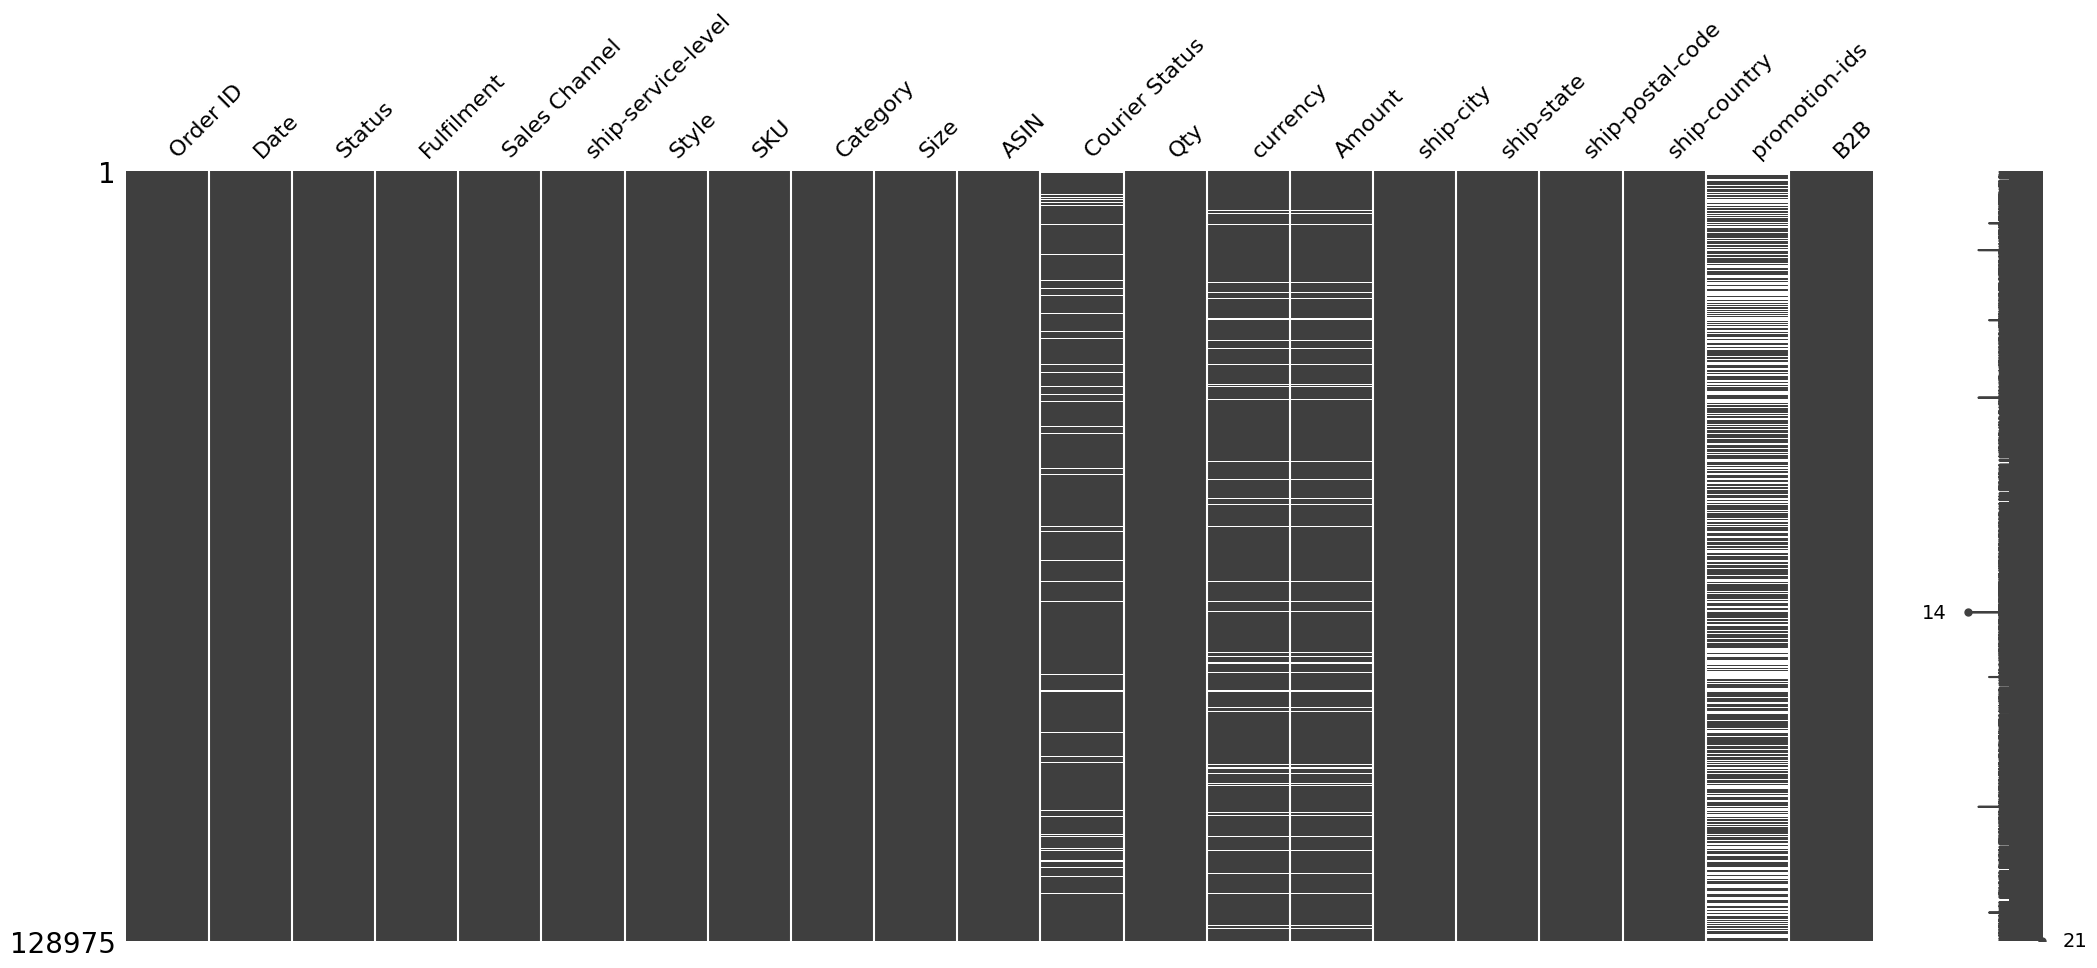

In [15]:
# Volvemos a usar missingno para visualizar los nulos
msno.matrix(df)

Nos guiamos con ayuda de: https://www.kaggle.com/code/dinaghettas/sales-eda. Sin embargo consideramos importante recalcar que el imputado no se pudo hacer con la moda para las siguientes variables:

* Amount: depende en gran medida de la cantidad comprada y colocar la moda puede dañar la data

In [18]:
# Actualizamos el porcentaje de nulos
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

# Creamos un DataFrame para mostrar los resultados
tabla_nulos = pd.DataFrame({
    'Columna': porcentaje_nulos.index,
    'Porcentaje de Nulos': porcentaje_nulos.values
})

# Filtramos solo las columnas con nulos
tabla_nulos = tabla_nulos[tabla_nulos['Porcentaje de Nulos'] > 0].sort_values(by='Porcentaje de Nulos', ascending=False)
tabla_nulos

,Columna,Porcentaje de Nulos
19,promotion-ids,38.110487
13,currency,6.043807
14,Amount,6.043807
11,Courier Status,5.328164
15,ship-city,0.025586
16,ship-state,0.025586
17,ship-postal-code,0.025586
18,ship-country,0.025586


El manejo de nulos por columna será el siguiente:

1) En todas las columnas iniciadas en "ship" usaremos la moda.
2) En currency, por lógica, usaremos "INR".
3) Amount tendrá un tratamiento especial. Trataremos de calcularlo de acuerdo a los productos por carrito.
4) Para promotion-ids asumiremos que en las celdas con nulos no se usó ninguna promoción (es decir, la compra fue hecha de manera habitual).
4) En Courier Status inputaremos "uknown".

In [19]:
# Inputamos la moda en todas las columnas iniciadas en "ship-"
df['Courier Status'] = df['Courier Status'].fillna(df['Courier Status'].mode()[0])
df['ship-city'] = df['ship-city'].fillna(df['ship-city'].mode()[0])
df['ship-state'] = df['ship-state'].fillna(df['ship-state'].mode()[0])
df['ship-postal-code'] = df['ship-postal-code'].fillna(df['ship-postal-code'].mode()[0])
df['ship-country'] = df['ship-country'].fillna(df['ship-country'].mode()[0])
df['currency']= df['currency'].fillna(df['currency'].mode()[0])

# Para promotion-ids, colocamos "No promotion applied" en los nulos
df['promotion-ids'] = df['promotion-ids'].fillna('No promotion applied')

# Para Courier Status colocamos "Uknown" en los nulos
df['Courier Status'] = df['Courier Status'].fillna('Unknown')

<Axes: >

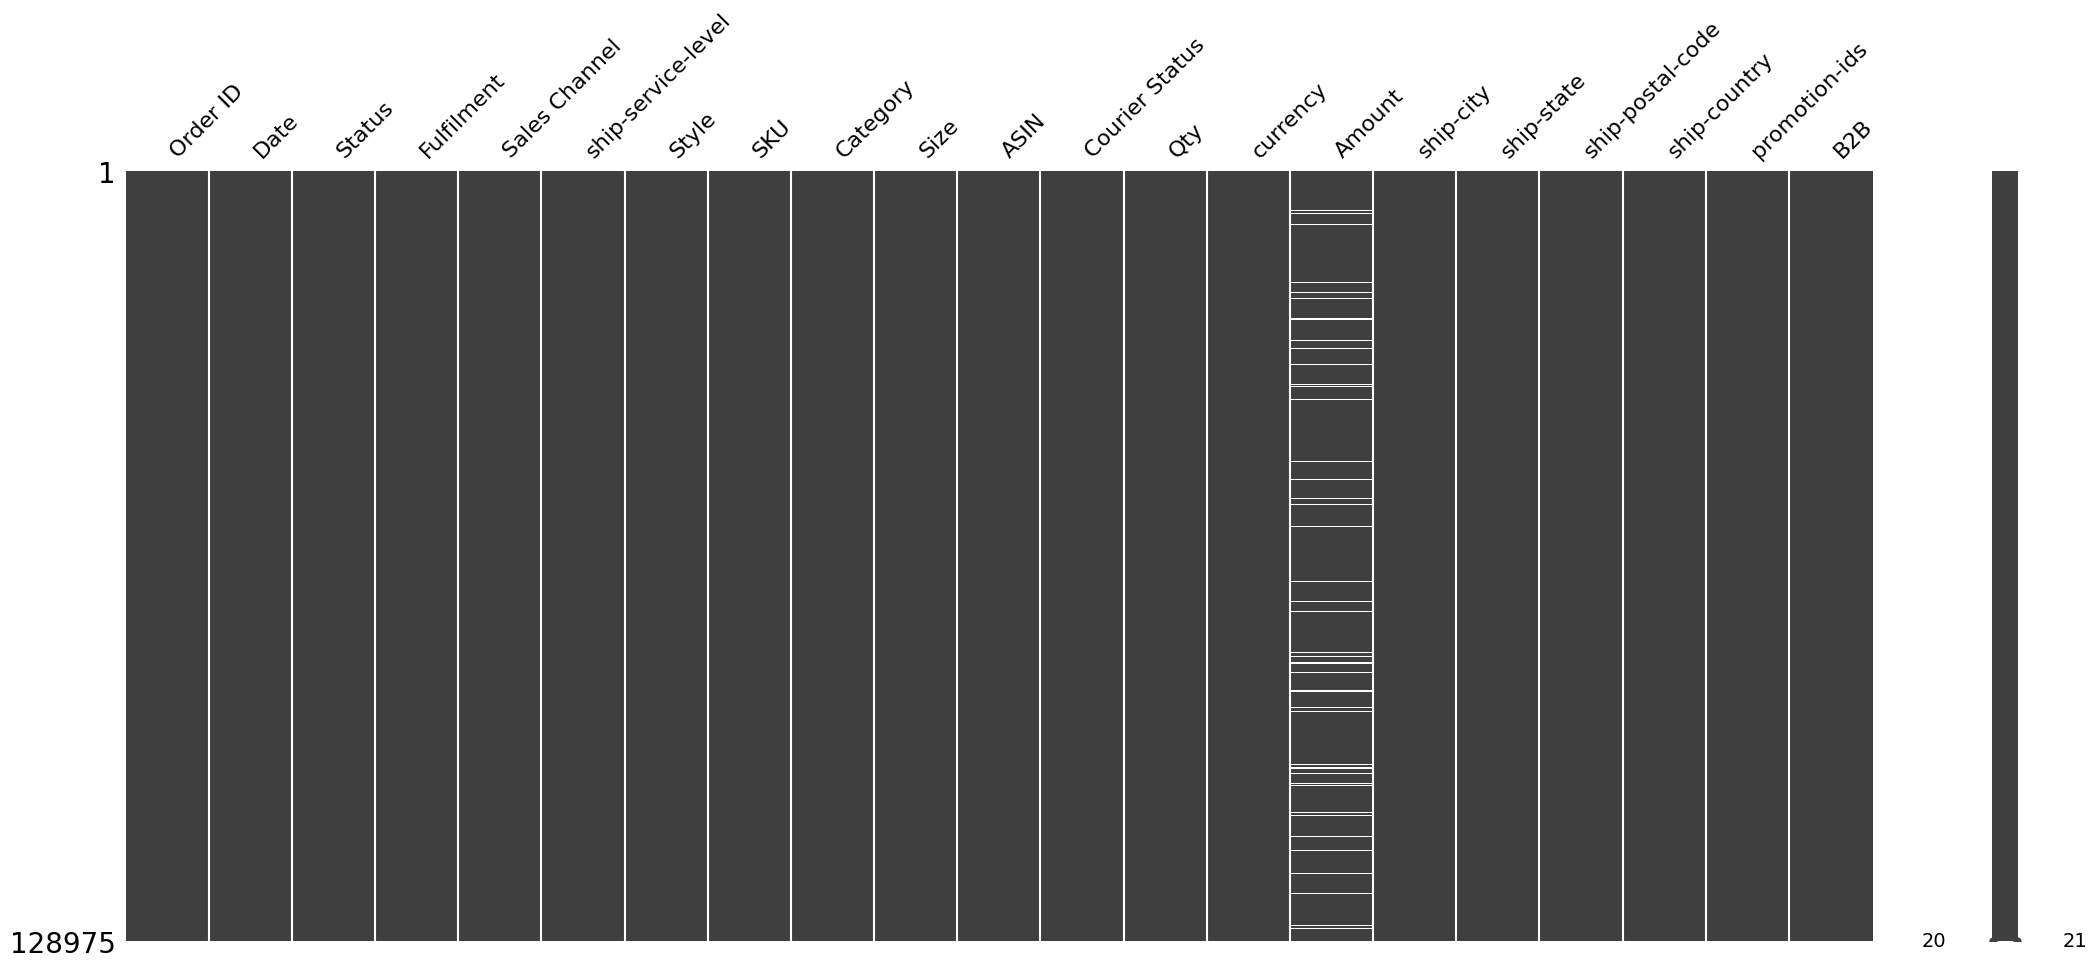

In [20]:
msno.matrix(df)

In [22]:
# Actualizamos el porcentaje de nulos
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

# Creamos un DataFrame para mostrar los resultados
tabla_nulos = pd.DataFrame({
    'Columna': porcentaje_nulos.index,
    'Porcentaje de Nulos': porcentaje_nulos.values
})

# Filtramos solo las columnas con nulos
tabla_nulos = tabla_nulos[tabla_nulos['Porcentaje de Nulos'] > 0].sort_values(by='Porcentaje de Nulos', ascending=False)
tabla_nulos

,Columna,Porcentaje de Nulos
14,Amount,6.043807


In [23]:
# Mostramos las columnas que tienen nulos
df.isnull().sum()

Order ID                 0
Date                     0
Status                   0
Fulfilment               0
Sales Channel            0
ship-service-level       0
Style                    0
SKU                      0
Category                 0
Size                     0
ASIN                     0
Courier Status           0
Qty                      0
currency                 0
Amount                7795
ship-city                0
ship-state               0
ship-postal-code         0
ship-country             0
promotion-ids            0
B2B                      0
dtype: int64

In [28]:
porcentaje_filas_nulas = (7795/df.shape[0]) * 100
print(f'Porcentaje de filas nulas: {porcentaje_filas_nulas:.2f}%')

Porcentaje de filas nulas: 6.04%


In [30]:
# Hacemos un dataframe con solo las filas nulas
df_nulos = df[df.isnull().any(axis=1)] 
df_nulos


,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,...,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B
index,,,,,,,,,,,,,,,,,,,,,
8,407-5443024-5233168,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,SET200,SET200-KR-NP-A-XXXL,Set,3XL,...,Cancelled,0,INR,NaN,HYDERABAD,TELANGANA,500008.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False
29,404-5933402-8801952,04-30-22,Cancelled,Merchant,Amazon.in,Standard,JNE2132,JNE2132-KR-398-XXXL,kurta,3XL,...,Shipped,0,INR,NaN,GUWAHATI,ASSAM,781003.0,IN,No promotion applied,False
65,171-4137548-0481151,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,JNE3373,JNE3373-KR-XXL,kurta,XXL,...,Cancelled,0,INR,NaN,Dahod,Gujarat,389151.0,IN,No promotion applied,False
84,403-9950518-0349133,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,JNE3510,JNE3510-KR-M,kurta,M,...,Cancelled,0,INR,NaN,HYDERABAD,TELANGANA,500072.0,IN,No promotion applied,False
95,405-9112089-3379536,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,JNE3405,JNE3405-KR-L,kurta,L,...,Cancelled,0,INR,NaN,PUNE,MAHARASHTRA,411046.0,IN,No promotion applied,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128903,406-3923120-4345139,05-31-22,Cancelled,Amazon,Amazon.in,Expedited,JNE3801,JNE3801-KR-M,kurta,M,...,Cancelled,0,INR,NaN,ANANTAPUR,ANDHRA PRADESH,515001.0,IN,No promotion applied,False
128907,403-6757403-6097100,05-31-22,Cancelled,Amazon,Amazon.in,Expedited,NW014,NW014-ST-SR-XXXL,Set,3XL,...,Cancelled,0,INR,NaN,GREATER NOIDA,UTTAR PRADESH,201306.0,IN,No promotion applied,False
128908,403-6757403-6097100,05-31-22,Cancelled,Amazon,Amazon.in,Expedited,NW007,NW007-ST-CP-XXXL,Set,3XL,...,Cancelled,0,INR,NaN,GREATER NOIDA,UTTAR PRADESH,201306.0,IN,No promotion applied,False


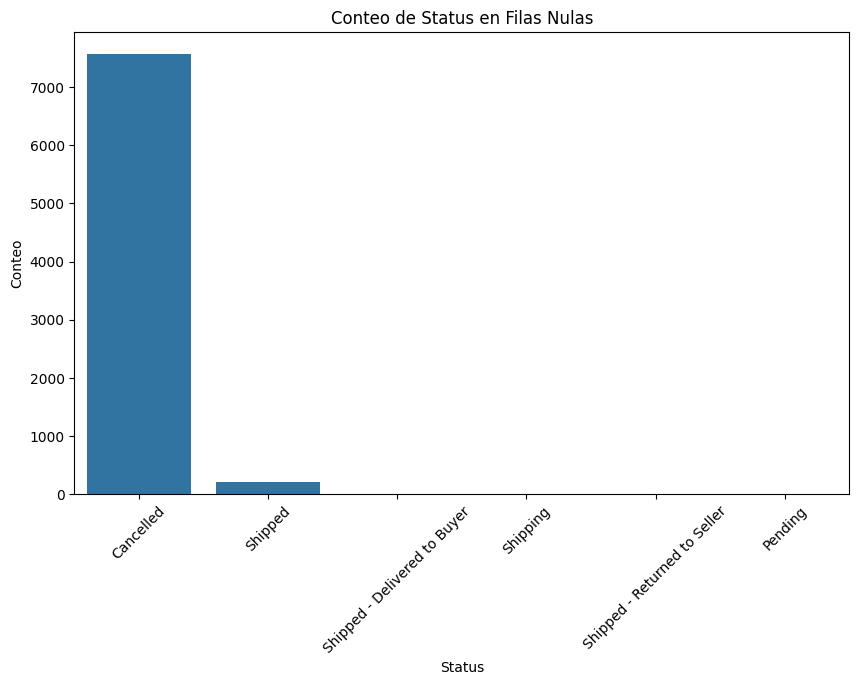

In [36]:
# Haremos una gráfica de barras para la columna "Status" en df_nulos
plt.figure(figsize=(10, 6))
sns.countplot(data=df_nulos, x='Status', order=df_nulos['Status'].value_counts().index)
plt.title('Conteo de Status en Filas Nulas')
plt.xlabel('Status')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()

INSIGHT: Podemos ver que en las filas con nulos, la gran mayoría de las órdenes fueron canceladas. Por lo tanto en las que digan "Cancelled" colocaremos "0" en Amount

In [37]:
# Si en "Status" dice "Cancelled" inputamos "0" en Amount
df.loc[df['Status'] == 'Cancelled', 'Amount'] = 0

# Actualizamos el porcentaje de nulos
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

# Creamos un DataFrame para mostrar los resultados
tabla_nulos = pd.DataFrame({
    'Columna': porcentaje_nulos.index,
    'Porcentaje de Nulos': porcentaje_nulos.values
})

# Filtramos solo las columnas con nulos
tabla_nulos = tabla_nulos[tabla_nulos['Porcentaje de Nulos'] > 0].sort_values(by='Porcentaje de Nulos', ascending=False)
tabla_nulos

,Columna,Porcentaje de Nulos
14,Amount,0.177554


In [38]:
# Hacemos un dataframe con solo las filas nulas
df_nulos = df[df.isnull().any(axis=1)] 
df_nulos

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,...,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B
index,,,,,,,,,,,,,,,,,,,,,
937,S02-5278980-4327051,04-30-22,Shipped,Amazon,Non-Amazon,Standard,BL017,BL017-63BLACK,Blouse,Free,...,Unshipped,15,INR,NaN,Surat,Gujarat,394210.0,IN,No promotion applied,False
1057,S02-9107114-0460608,04-30-22,Shipped,Amazon,Non-Amazon,Standard,SET315,SET315-KR-PP-XL,Set,XL,...,Unshipped,2,INR,NaN,Surat,Gujarat,394210.0,IN,No promotion applied,False
1615,405-7790745-1369118,04-29-22,Shipped,Amazon,Amazon.in,Expedited,JNE3518,JNE3518-KR-M,kurta,M,...,Cancelled,0,INR,NaN,RISHIKESH,UTTARAKHAND,249201.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False
1989,171-9673855-2321133,04-29-22,Shipped,Amazon,Amazon.in,Expedited,SET232,SET232-KR-PP-S,Set,S,...,Cancelled,0,INR,NaN,DHARUHERA,HARYANA,123106.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False
2424,404-7478762-7926753,04-29-22,Shipped,Amazon,Amazon.in,Expedited,SET331,SET331-KR-NP-S,Set,S,...,Cancelled,0,INR,NaN,Gangapur city,Rajshthan,322201.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124616,S02-2059602-9568060,06-04-22,Shipped,Amazon,Non-Amazon,Standard,JNE3577,JNE3577-KR-S,kurta,S,...,Unshipped,1,INR,NaN,Surat,Gujarat,394210.0,IN,No promotion applied,False
124617,S02-3811761-8377519,06-04-22,Shipped,Amazon,Non-Amazon,Standard,J0103,J0103-SKD-XS,Set,XS,...,Unshipped,2,INR,NaN,Surat,Gujarat,394210.0,IN,No promotion applied,False
124619,S02-5216693-3162561,06-04-22,Shipped,Amazon,Non-Amazon,Standard,SET154,SET154-KR-NP-XXL,Set,XXL,...,Unshipped,1,INR,NaN,Surat,Gujarat,394210.0,IN,No promotion applied,False


In [39]:
porcentaje_filas_nulas = (229/df.shape[0]) * 100
print(f'Porcentaje de filas nulas: {porcentaje_filas_nulas:.2f}%')

Porcentaje de filas nulas: 0.18%


<Axes: >

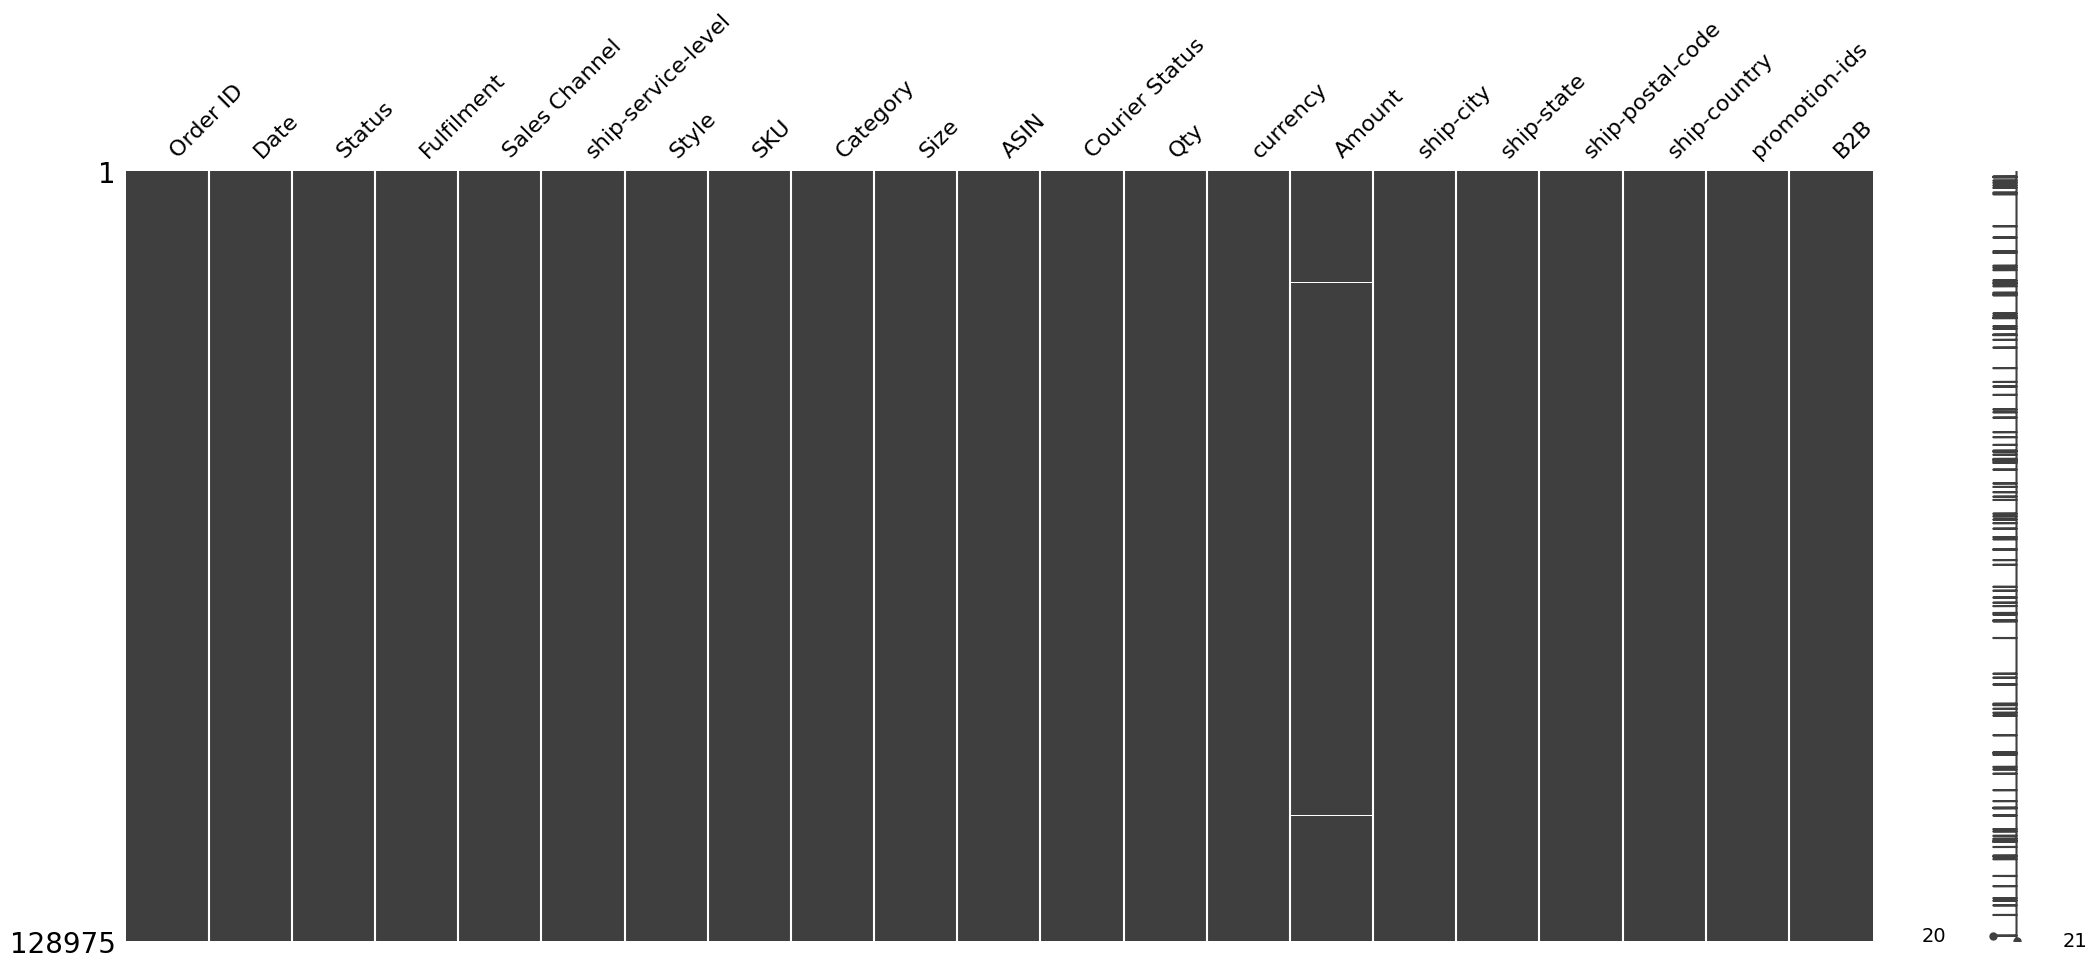

In [40]:
msno.matrix(df)

In [41]:
# Eliminamos las filas nulas
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128746 entries, 0 to 128974
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Order ID            128746 non-null  object 
 1   Date                128746 non-null  object 
 2   Status              128746 non-null  object 
 3   Fulfilment          128746 non-null  object 
 4   Sales Channel       128746 non-null  object 
 5   ship-service-level  128746 non-null  object 
 6   Style               128746 non-null  object 
 7   SKU                 128746 non-null  object 
 8   Category            128746 non-null  object 
 9   Size                128746 non-null  object 
 10  ASIN                128746 non-null  object 
 11  Courier Status      128746 non-null  object 
 12  Qty                 128746 non-null  int64  
 13  currency            128746 non-null  object 
 14  Amount              128746 non-null  float64
 15  ship-city           128746 non-null  ob

In [ ]:
# Exportamos el dataset limpio
# ruta_limpio = '/workspaces/The-Stock-Stack/datasets/amazon_sale_report_limpio.csv'
# df.to_csv(ruta_limpio, index=False)
print('Dataset limpio exportado')

Dataset limpio exportado


# 3) Iniciamos el EDA

In [43]:
ruta_limpio = '/workspaces/The-Stock-Stack/datasets/amazon_sale_report_limpio.csv'
df = pd.read_csv(ruta_limpio)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128746 entries, 0 to 128745
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Order ID            128746 non-null  object 
 1   Date                128746 non-null  object 
 2   Status              128746 non-null  object 
 3   Fulfilment          128746 non-null  object 
 4   Sales Channel       128746 non-null  object 
 5   ship-service-level  128746 non-null  object 
 6   Style               128746 non-null  object 
 7   SKU                 128746 non-null  object 
 8   Category            128746 non-null  object 
 9   Size                128746 non-null  object 
 10  ASIN                128746 non-null  object 
 11  Courier Status      128746 non-null  object 
 12  Qty                 128746 non-null  int64  
 13  currency            128746 non-null  object 
 14  Amount              128746 non-null  float64
 15  ship-city           128746 non-nul

In [44]:
df.head()

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,...,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,Shipped,0,INR,0.0,MUMBAI,MAHARASHTRA,400081.0,IN,No promotion applied,False
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,Shipped,1,INR,406.0,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,Shipped,1,INR,329.0,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True
3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,...,Shipped,0,INR,0.0,PUDUCHERRY,PUDUCHERRY,605008.0,IN,No promotion applied,False
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,Shipped,1,INR,574.0,CHENNAI,TAMIL NADU,600073.0,IN,No promotion applied,False


El dataframe, como puede verse, está listo para empezar a ser trabajado. Se le retiraron las filas que no aportaban y se le inputaron los datos que hacían falta. Procederemos ahora a responder las preguntas semilla.

### 2.1) ¿Cuáles productos tendrán mayor demanda el próximo mes?